In [34]:
from functools import partial

import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [35]:
class DataGenerator:
    def __init__(
        self,
        target_distribution: callable,
        treatment_effect: float = 0.0,
        decay_factor: float = 1.0,
        total_panel: int = 7,
        control_group: bool = True
    ):
        self.target_distribution = target_distribution
        self.treatment_effect = treatment_effect
        self.decay_factor = decay_factor
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-decay_factor*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        full_panel_data = np.clip(self.target_distribution(size=(n_samples, self.total_panel)), a_min=0, a_max=np.inf)
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data

In [36]:
control_dg = DataGenerator(
    target_distribution=partial(np.random.normal, loc=0, scale=1),
    treatment_effect=0,
    decay_factor=0.1,
    total_panel=52,
    control_group=True
)
control_dg.generate_data(n_samples=10)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,0.174827,0.000000,0.627977,0.073737,24.001868,0
1,0.000000,1.305643,0.072533,0.619218,22.460695,0
2,0.000000,0.000000,0.800208,0.000000,14.856127,0
3,1.490170,0.000000,0.000000,0.557834,26.941573,0
4,0.000000,0.340268,0.000000,0.000000,26.143878,0
5,0.563860,0.000000,0.000000,0.000000,22.124143,0
6,0.000000,0.000000,1.176805,0.572632,13.812383,0
7,1.270424,0.877584,0.970003,0.000000,26.046967,0
8,2.070357,0.000000,0.000000,1.326963,25.256831,0
9,0.000000,0.000000,0.000000,0.719000,21.241521,0


In [37]:
test_dg = DataGenerator(
    target_distribution=partial(np.random.choice, a=[0, 1, 2], p=[0.75, 0.24, 0.01]),
    treatment_effect=0.5,
    decay_factor=0.1,
    total_panel=52,
    control_group=False
)
test_dg.generate_data(n_samples=10)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,0.5,1.452419,0.409365,0.370409,17.225181,1
1,1.5,0.452419,0.409365,0.370409,18.225181,1
2,0.5,0.452419,0.409365,0.370409,10.225181,1
3,0.5,0.452419,0.409365,0.370409,14.225181,1
4,1.5,0.452419,0.409365,0.370409,21.225181,1
5,1.5,0.452419,1.409365,0.370409,18.225181,1
6,0.5,0.452419,0.409365,0.370409,20.225181,1
7,1.5,0.452419,0.409365,1.370409,16.225181,1
8,1.5,0.452419,0.409365,0.370409,17.225181,1
9,0.5,0.452419,1.409365,0.370409,21.225181,1


In [38]:
def generate_train_data(n_samples=1000, n_surrogates: int = 6, dist:callable = partial(np.random.normal, loc=0, scale=1)) -> pd.DataFrame:
    dg = DataGenerator(treatment_effect=0.0, control_group=False, target_distribution=dist)
    train_data = dg.generate_data(n_samples=n_samples, n_surrogates=n_surrogates)
    return train_data

def generate_test_data(n_samples:int = 1000, treatment_effect:float=0.5, decay_factor:float = 1, n_surrogates: int = 6, dist:callable = partial(np.random.normal, loc=0, scale=1)) -> pd.DataFrame:
    dg_c = DataGenerator(treatment_effect=0.0, control_group=True, target_distribution=dist)
    dg_t = DataGenerator(treatment_effect=treatment_effect, decay_factor=decay_factor, control_group=False, target_distribution=dist)
    control_data = dg_c.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    treatment_data = dg_t.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    test_data = pd.concat([control_data, treatment_data])
    return test_data

def estimate_treatment_effect(data:pd.DataFrame, outcome_col:str, treatment_col:str, return_p_value:bool=False) -> float:
    model = smf.ols(f"{outcome_col} ~ {treatment_col}", data=data)
    result = model.fit()
    if return_p_value:
        return result.params[treatment_col], result.pvalues[treatment_col]
    else:
        return result.params[treatment_col]

def add_sim_fit(train_data:pd.DataFrame, test_data:pd.DataFrame,  outcome_col:str, n_surrogates:int = 6,) -> pd.DataFrame:
    model = smf.ols(f"{outcome_col} ~ {' + '.join([f'surrogate_{i}' for i in range(n_surrogates)])}", data=train_data)
    result = model.fit()
    aug_data = (
        test_data
        .assign(**{
            outcome_col: lambda df: result.predict(df)
        })
    )
    return aug_data

In [42]:
dist_space = [
    ('poisson 5', partial(np.random.poisson, lam=5)),
    # ('multicat', partial(np.random.choice, a=[0, 1, 2], p=[0.75, 0.24, 0.01])),
    # ('exponential 1', partial(np.random.exponential, scale=1)),
    # ('normal 0 1', partial(np.random.normal, loc=0, scale=1)),
]
estimate_df_list = list()
for dist_name, dist in dist_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=2, n_surrogates=6, dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name
        )
    )

    estimate_df_list.append(full_estimate_df)

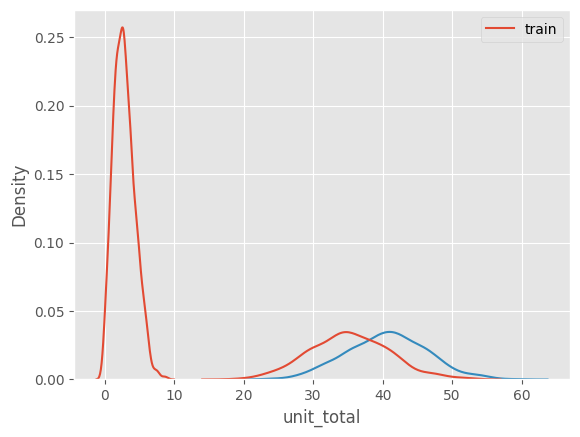

In [44]:
ax = sns.kdeplot(data=train_data, x='unit_total', label='train')
sns.kdeplot(data = test_data, x='unit_total', hue = 'treatment', ax=ax)
ax.legend()

<Axes: xlabel='unit_total', ylabel='Density'>

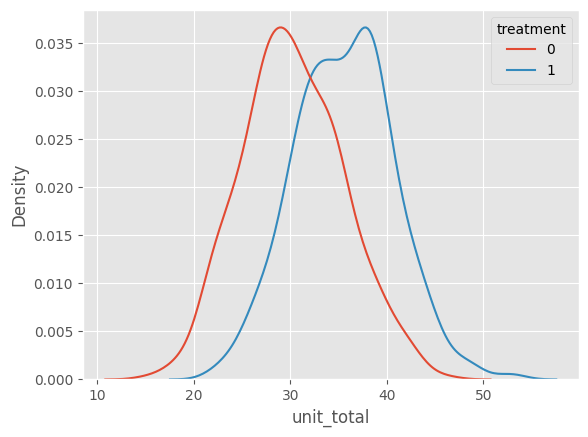

In [47]:
# ax = sns.kdeplot(data=test_data, x='unit_total',  hue = 'treatment')
sns.kdeplot(data = aug_data, x='unit_total', hue = 'treatment')

In [40]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist
0,5.558583,5.459104e-46,5.415217,5.404996e-50,0.143367,poisson 5
1,5.350583,1.430773e-42,4.942351,3.224273e-46,0.408232,poisson 5
2,4.884583,1.658318e-36,4.913901,1.267423e-43,-0.029318,poisson 5
3,6.028583,6.876313e-51,6.090732,8.106646e-60,-0.062149,poisson 5
4,5.640583,2.036473e-43,5.571877,1.239452e-47,0.068706,poisson 5


Text(0, 0.5, 'Difference in ATE\nobserved vs. prediction data')

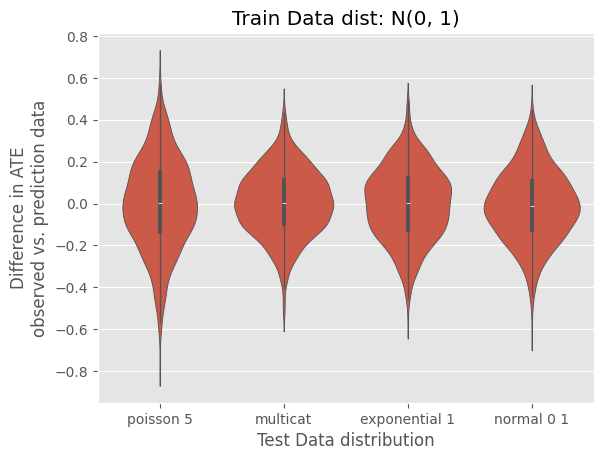

In [41]:
ax = sns.violinplot(
    data = estimate_df,
    x='dist',
    y='diff_estimates'
)
ax.set_title('Train Data dist: N(0, 1)')
ax.set_xlabel('Test Data distribution')
ax.set_ylabel('Difference in ATE\nobserved vs. prediction data')
